# Gradient Boosting (Part II)
## Troubleshooting Our Model
So we saw that our first GBT approach in the last post was, to quote myself, a "steaming pile of hot garbage". In reality, that's probably and understatement because it's barely even a model. I could've gotten the results with literally no model and straight guesses. Disappointing to say the least.

![](http://i.imgur.com/8zXjYXy.gif)

Of course, now, the question is... Why? Why is this model so bad? There are so many things that could have gone wrong:
1. Did I misclassify some songs in my library in theory?
2. Did I misclassify some songs in my library in practice (i.e. accidentally classified a Rock song as R&B)?
3. Is my feature extraction method appropriate (i.e. MFCCs)?
4. Is gradient boosting appropriate for this application?
5. Did I take enough gradient boosting iterations to really allow the model settle and optimize?

So many questions. So little answers... The solutions to the above would be
1. Re-think my classifications of genres and re-classify my entire library, this may include adding new genres, taking away existing genres, or switching songs from one genre to another.
2. Thoroughly check all 4000 songs again for mistakes.
3. Do another week of research regarding feature extraction methods for music.
4. Try other models (neural network).
5. Leave the model running overnight / get a faster CPU (AWS?).

I'm going to try to tweak \#1 purely on the basis that it's probably the least time consuming solution... a quick win _**IF**_ it works, and not too big of a sunk cost if it doesn't. I'm actually going to approach \#1 in a way that should mitigate the effects of \#2, \#3, and \#5 as well. I'm going to take two very distinct genres of equal population and try to run the model only on those 2. Let's take Rock and Easy Listening for now because they should be quite different (the Radioheads and Portisheads come to mind that could _**kind of**_ cross over semetimes, but for the most part they're quite different).

With only these two genres, we're dealing with less than 10% of our original data set. We're also taking the more ambiguous genres out (e.g. Dance, R&B, Hip Hop and Jazz have more overlap than Rock and Easy Listening). With this, I'll get more confidence in whether or not MFCCs do the job as well.

In [1]:
# Enable plots in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Seaborn makes our plots prettier
import seaborn
seaborn.set(style = 'ticks')

import numpy as np
import pandas as pd
import random

import sklearn

In [2]:
# Load the dataset we generated in the previous post
my_itunes_data = pd.read_csv(
    '../features.csv', 
    header = None,
    names = [
        'song_id',
        'title',
        'artist',
        'genre',
        'mfcc_1',
        'mfcc_2',
        'mfcc_3',
        'mfcc_4',
        'mfcc_5',
        'mfcc_6',
        'mfcc_7',
        'mfcc_8',
        'mfcc_9',
        'mfcc_10'
    ]
)

In [3]:
# Check that the data imported properly
my_itunes_data.dtypes

song_id      int64
title       object
artist      object
genre       object
mfcc_1     float64
mfcc_2     float64
mfcc_3     float64
mfcc_4     float64
mfcc_5     float64
mfcc_6     float64
mfcc_7     float64
mfcc_8     float64
mfcc_9     float64
mfcc_10    float64
dtype: object

In [4]:
# Check number of rows in the data set
my_itunes_data.shape[0]

2470678

In [5]:
# Check the number of songs
my_itunes_data['song_id'].nunique()

3825

In [6]:
# Remove any training samples with "Prince" as artist
my_itunes_data = my_itunes_data[(my_itunes_data['genre'].isin(['Rock', 'Easy Listening']))]

# Check the number of songs
my_itunes_data['song_id'].nunique()

208

We're dealing with wayyyyy less songs now.

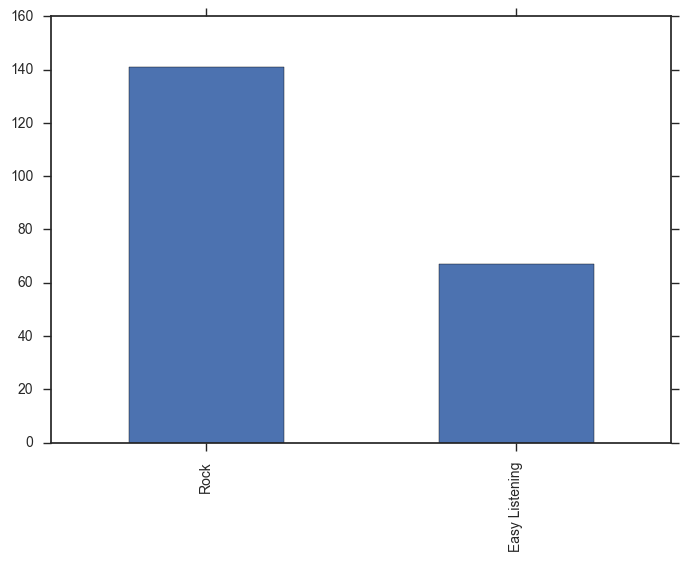

In [7]:
# Aggregate data to song level to see how many songs are of each genre
my_itunes_data[['song_id', 'genre']].drop_duplicates()['genre'].value_counts().plot(kind = 'bar')

We got about twice the number of Rock songs than Easy Listening, but should be fine.

In [8]:
# Get the list of unique song_id's
unique_song_ids = my_itunes_data['song_id'].unique()

# Get ~10% of the test data
test_song_ids = random.sample(unique_song_ids, 25)

# All other songs become the training set
train_song_ids = [x for x in unique_song_ids if x not in test_song_ids]

print 'There are {} songs in the training set and {} songs in the test set'.format(len(train_song_ids), len(test_song_ids))

There are 183 songs in the training set and 25 songs in the test set


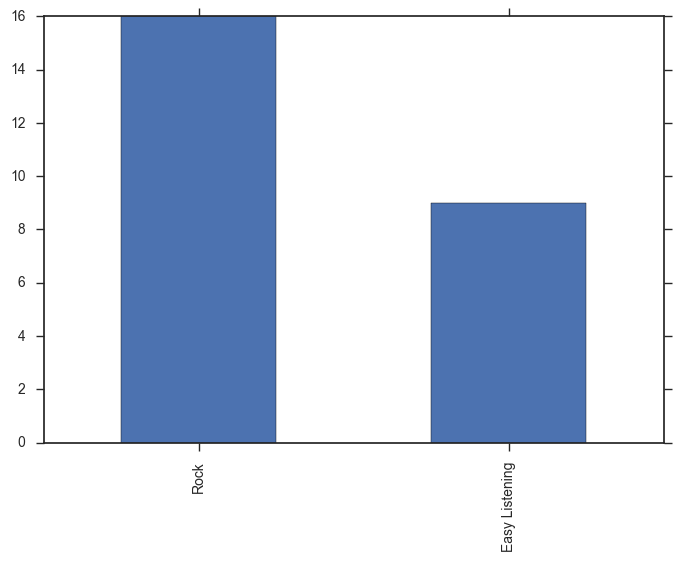

In [9]:
# Check the distribution of genres in the test set to ensure the sample is not completely lop-sided
my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)][['song_id', 'genre']].drop_duplicates()['genre'].value_counts().plot(kind = 'bar')

Looking good. Let's train.

In [10]:
# Build training set
x_train = my_itunes_data[my_itunes_data['song_id'].isin(train_song_ids)].filter(regex = 'mfcc.*').values
y_train = my_itunes_data[my_itunes_data['song_id'].isin(train_song_ids)][['genre']].values.T[0]
print 'There are {} training samples'.format(len(x_train))

# Build test set
x_test = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)].filter(regex = 'mfcc.*').values
y_test = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)][['genre']].values.T[0]
print 'There are {} test samples'.format(len(x_test))

There are 118218 training samples
There are 16150 test samples


In [11]:
# Import xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [12]:
# Encode our labels to integers (e.g. "Dance" becomes a number like 1 or 2)
lb = LabelEncoder()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)
print 'Y (train) set has the following labels {} and has {} elements'.format(np.unique(y_train_encoded), len(y_train_encoded))
print 'Y (test) set has the following labels {} and has {} elements'.format(np.unique(y_test_encoded), len(y_test_encoded))

Y (train) set has the following labels [0 1] and has 118218 elements
Y (test) set has the following labels [0 1] and has 16150 elements


In [13]:
# Fit our train and test data to a xgb sparse matrix
xgb_train = xgb.DMatrix(x_train, label = y_train_encoded)
xgb_test = xgb.DMatrix(x_test, label = y_test_encoded)
xgb_test_no_label = xgb.DMatrix(x_test)

In [52]:
# Set xgboost parameters
param = {
    'max_depth': 1,
    'nthread': 2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1
}

num_rounds = 10000

eval_list  = [(xgb_train, 'train'), (xgb_test, 'eval')]

This great. We can train our model MUCH faster.

In [54]:
# Train model
bst = xgb.train(param, xgb_train, num_rounds, eval_list, early_stopping_rounds = 250, verbose_eval = False)

In [62]:
# Define a function to output best model info
def best_model_info(bst):
    print 'The best model was on iteration {} with a score of {}'.format(bst.best_iteration, bst.best_score)
    
# View best model info from last train
best_model_info(bst)

The best model was on iteration 176 with a score of 0.549914


Since we only have 2 classes for this example, we can actually use xgboost to evaluate the AUC rather than straight classification error. AUC will give us a better sense of how well the model is able to separate out sensitivity and specificity of the classes. Because each iteration of xgboost is so fast here, I can also just set the maximum number of rounds to something crazy like 10,000 and set the early_stopping_rounds parameter as well. As we saw in the R implementation, early_stopping_rounds simply allows us to run the model into oblivion and xgboost itself will automatically stop when the evaluation metric doesn't get better for, as we've set here, 250 iterations. Here, I turned 'silent': 1 in the model params verbose_eval = False in the train command to surpess the information because the bst parameter should give us all the information we need without needing to see every iteration's information.

Since our model is training so fast, we can tweak a few parameters... one that I've been ignoring is the eta parameter which controls the learning rate. The xgboost default is 0.3 which isn't that big, but we can decrease it even more because time we have time to spare with the model training so quickly.

In [65]:
# Tweak eta parameter
param_eta_01 = param
param_eta_01['eta'] = 0.1

# Train model
bst_eta_01 = xgb.train(param, xgb_train, num_rounds, eval_list, early_stopping_rounds = 250, verbose_eval = False)

In [66]:
# View best model info from last train
best_model_info(bst_eta_01)

The best model was on iteration 1558 with a score of 0.54947


We're not doing much better here. I doubt things would change if we slowed it down even more but...

In [63]:
# Tweak eta parameter
param_eta_005 = param
param_eta_005['eta'] = 0.05

# Train model
bst_eta_005 = xgb.train(param, xgb_train, num_rounds, eval_list, early_stopping_rounds = 250, verbose_eval = False)

In [64]:
# View best model info from last train
best_model_info(bst_eta_005)

The best model was on iteration 768 with a score of 0.548409


Hmm, it actually took less iterations to train at a learning rate of 0.05 than at 0.1. I can maybe attribute that to the luck of the draw in that the 0.1 step size may have just made a few splits that prolonged the training process, where 0.05 was able to get to the point a bit faster. Regardless, we se a similar AUC, and it's not good.

![](https://media.giphy.com/media/yisc7FaqoEfjG/giphy.gif)

I just want to take a bit of a deeper dive to see which songs were classified what just to see if I can find out a bit more information that way.

In [68]:
# Predict test
y_test_pred = bst_eta_005.predict(xgb_test_no_label, ntree_limit = bst_eta_005.best_ntree_limit)
y_test_pred = [int(x) for x in y_test_pred]

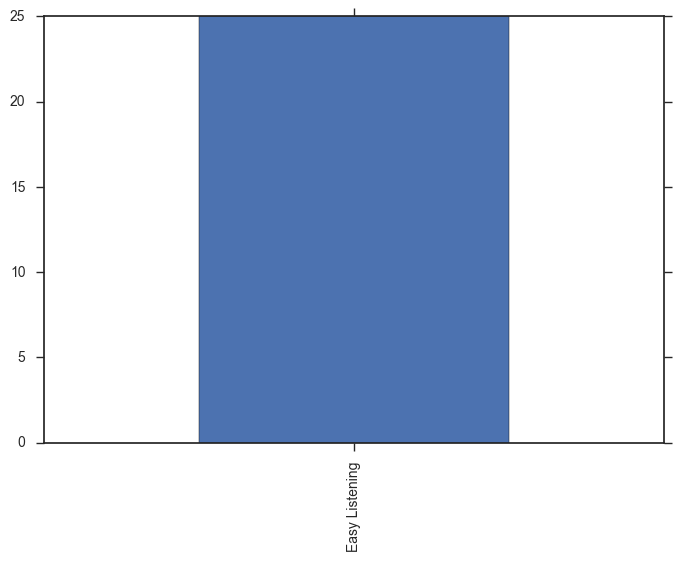

In [69]:
# Create a new dataframe with just the song ids
x_test_song_id_labels = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)][['song_id']].reset_index(drop = True)

# Append the predicted values to the song ids
x_test_song_id_labels['y_test_pred'] = pd.Series(lb.inverse_transform(y_test_pred))

# Group by and find the most commonly classified genre of each frame per song
song_classification = x_test_song_id_labels.groupby(['song_id'])['y_test_pred'].agg(lambda x: x.value_counts().idxmax()).reset_index()

# Plot histogram of predicted song genres
song_classification['y_test_pred'].value_counts().plot(kind = 'bar')

Oh wow, that's quite unexpected... it thinks everything is easy listening. Okay then. This doesn't quite solve any of the problems I had haha... probably just creates more to be honest. There is still a chance that my music classification is wrong, and there is still a chance that I'm extracting MFCCs wrong or that MFCCs are a wrong way to approach the problem in general. There is one _**last**_ thing I can try to tweak in the xgboost model, and that's the depth of the trees. I don't expect much of a difference, but let's give it a shot. Since we're playing around with multiple parameters here, I'm actually going to try the GridSearchCV function from sklearn.

The GridSearchCV essentially allows us to
1. Perform cross validation (which we had not been doing before, we were only using a single train test split)
2. Loop through multiple parameters efficiently

I have to caveat this right now by saying that _**MY METHOD OF CV RIGHT NOW MAY BE INACCURATE**_. Cross validation helps decrease the out-of-sample error by splitting our data up into multiple folds and training and testing multiple times. For example, for 5-fold cross validation, each iteration would look something like this:

![](http://tomaszkacmajor.pl/wp-content/uploads/2016/05/cross-validation.png)

Notice that each set is split up into 1 parts, and in each iteration, 4 of them are used as training and 1 of them is used as the test. The reason I wasn't using CV before, and only train test split, was because each of my training samples are _**frames of songs**_, not the _**actual songs themselves**_. Because they are frames, I may be training on parts of one song, and testing on other parts. Although, in theory, each sample is individual from each other, the logic in the context we're working in (music and songs) says we should be training and testing on _**songs**_ themselves.

For me to run cross validation, let alone cross validation over a grid of parameters like GridSearchCV does, I'd have to write custom code (like I did with the train test split method) to not just randomly take 20% of my sample, but 20% of my sample _**in terms of songs**_, which ends up being 20% of the overall samples in general because I took the same amount of samples per song. I should never be training on 50% of one song and testing on 50% of another song.

But with that entire rant, I'm going to go ahead and actually do exactly that because my objective here is just to scratch the surface on if parameters make a big difference, not do a deep dive. This should give me enough of an idea because I think I should still see a bump in accuracy.

To learn how GridSearchCV works with xgboost, I'm referring to [this kaggle page](https://www.kaggle.com/phunter/xgboost-with-gridsearchcv)

In [16]:
from sklearn.grid_search import GridSearchCV

In [90]:
# Instantiate model
xgb_model_test = xgb.XGBClassifier()

# Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
param_grid_search_test = {
#     'max_depth': [1, 5, 10],
#     'learning_rate': [0.05, 0.1, 0.5, 1, 2],
    'max_depth': [1],
    'objective': ['binary:logistic'],
    'silent': [1],
#     'n_estimators': 1000
    'n_estimators': [200]
}

# Set up grid search
clf_test = GridSearchCV(
    xgb_model_test, 
    param_grid_search_test, 
    n_jobs = -1, 
    cv = 5, 
    scoring = 'roc_auc',
    verbose = 1, 
    refit = True
)

In [15]:
# Suppress warnings because I'm getting a deprecation warning
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Fit model
clf_test.fit(x_train, y_train_encoded)

In [86]:
print clf_test.best_score_
print clf_test.best_params_

0.540156962394
{'n_estimators': 200, 'objective': 'binary:logistic', 'max_depth': 1, 'silent': 1}


I just tried a test run above, and I've gotten the model to train! Hurrah! You'll see that my parameters list contains some commented out values of parameters that I actually want to train, but I just wanted to do a test run first because I could be waiting a while if something went wrong. Training 5 models (1 model with 5 CV) took about 45 seconds here, so not bad!

I'm going to extend this training process, first of all, by using 1000 iterations instead of 200. I'm then going to add 12x more models (3 max_depth values and 4 eta values), in certain cases using larger tree depths, and using slower learning rates as well. Let's try it anyways.

In [106]:
# Instantiate model
xgb_model = xgb.XGBClassifier()

# Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
param_grid_search = {
    'max_depth': [1, 5, 10],
    'learning_rate': [0.05, 0.1, 0.5, 1, 2],
    'objective': ['binary:logistic'],
    'silent': [1],
    'n_estimators': [1000]
}

# Set up grid search
clf = GridSearchCV(
    xgb_model, 
    param_grid_search, 
    n_jobs = -1, 
    cv = 5, 
    scoring = 'roc_auc',
    verbose = 2, 
    refit = True
)

In [107]:
# Fit model
clf.fit(x_train, y_train_encoded)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 -  48.5s
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 -  48.9s
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 -  46.5s
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 -  46.5s
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.05, max_depth=1, silent=1 
[CV] n_estimators=1000, objective=binary:logistic, learni

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 484.7min


[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 - 5.5min
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 - 5.1min
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=10, silent=1 
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=5, silent=1 - 3.5min
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=10, silent=1 
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=10, silent=1 - 7.3min
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=10, silent=1 
[CV]  n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=10, silent=1 - 7.3min
[CV] n_estimators=1000, objective=binary:logistic, learning_rate=0.5, max_depth=10, silent=1 
[CV]  n_estimators=

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 556.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'objective': ['binary:logistic'], 'n_estimators': [1000], 'learning_rate': [0.05, 0.1, 0.5, 1, 2], 'max_depth': [1, 5, 10], 'silent': [1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [109]:
print clf.best_score_
print clf.best_params_

0.687249669247
{'n_estimators': 1000, 'objective': 'binary:logistic', 'learning_rate': 0.05, 'max_depth': 5, 'silent': 1}


Wow, that actually made quite a difference. We see with a slower learning rate and more depth in our trees, we've gained ~15% more area under our ROC curve! That's awesome. At the risk of sounding like an addict, I must go deeper here.

<img src="http://i0.kym-cdn.com/photos/images/facebook/000/531/557/a88.jpg" style="width: 400px;"/>

Let me re-run the model with even more fine-tuned learning rates and max\_depths. I also bumped the number of rounds up to 10,000 becauwe we are using _**much smaller step sizes**_ (learning rates / etas). I've also just found out that you can implement xgboost early stopping in conjunction with GridSearchCV as well... life just keeps getting better... goodness gracious. One caveat of this is that, when we implmented early stopping before, we had a consistent training set and a consistent test set. This made sense because, while our training error keeps decreasing, our test error is what our early stopping measured on. If the test error doesn't improve in however many specified iterations, we stop the process altogether because it looks like we've found a minimum in test error. When we're doing cross validation, _**our training set is always changing**_. There exists a chance that our randomly defined training set actually overlaps with our test set specified for early stopping, and that the test error will keep decreasing with the CV train error. Our training set created by CV, however, takes up 80% of our data because we're using 5-fold CV, and our early stopping test set takes up 10% of our data because I've defined that number at the top of the script, so already our two data sets _**overlap directly, even by pure chance**_, but I won't pretend like there doesn't exist any possibility of correlation here.

In [21]:
# Instantiate model
xgb_model_detailed = xgb.XGBClassifier()

# Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
param_detailed = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.05],
    'objective': ['binary:logistic'],
    'silent': [1],
    'n_estimators': [10000]
}

fit_params_detailed = {
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'eval_set': [[x_test, y_test_encoded]],
    'verbose': 1000
}

# Set up grid search
clf_detailed = GridSearchCV(
    xgb_model_detailed,
    param_detailed,
    fit_params = fit_params_detailed,
    n_jobs = -1,
    cv = 5, 
    scoring = 'roc_auc',
    verbose = 2,
    refit = True
)

In [22]:
# Fit model
clf_detailed.fit(x_train, y_train_encoded)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.01, max_depth=3, silent=1 
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.01, max_depth=3, silent=1 
[0]	validation_0-auc:0.513271
Will train until validation_0-auc hasn't improved in 200 rounds.
[0]	validation_0-auc:0.512725
Will train until validation_0-auc hasn't improved in 200 rounds.
[1000]	validation_0-auc:0.687086
[1000]	validation_0-auc:0.662171
[2000]	validation_0-auc:0.699414
[2000]	validation_0-auc:0.675056
[3000]	validation_0-auc:0.705612
[3000]	validation_0-auc:0.684401
[4000]	validation_0-auc:0.715883
[4000]	validation_0-auc:0.693425
Stopping. Best iteration:
[4018]	validation_0-auc:0.716013

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.01, max_depth=3, silent=1 - 9.5min
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.01, max_depth=3, silent=1 
[0]	validation_0-auc:0.593536
Will tr

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 132.1min


[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=5, silent=1 
[0]	validation_0-auc:0.61347
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[557]	validation_0-auc:0.749785

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=5, silent=1 - 3.6min
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=5, silent=1 
[0]	validation_0-auc:0.634673
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[684]	validation_0-auc:0.732199

[CV]  n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=5, silent=1 - 3.6min
[CV] n_estimators=10000, objective=binary:logistic, learning_rate=0.05, max_depth=7, silent=1 
[0]	validation_0-auc:0.656364
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[773]	validation_0-auc:0.739917

[CV]  n_estimators=10000, objective=binary:log

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 144.8min finished


[0]	validation_0-auc:0.659962
Will train until validation_0-auc hasn't improved in 200 rounds.
[1000]	validation_0-auc:0.741186
Stopping. Best iteration:
[1313]	validation_0-auc:0.743315



GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'eval_set': [[array([[-0.79214, -0.86342, ..., -0.471  ,  0.54577],
       [-0.71002, -1.34797, ..., -0.48109,  0.98213],
       ...,
       [-0.27992, -1.74503, ..., -0.55762, -0.31676],
       [-0.24504, -0.71002, ..., -0.49514, -0.19996]]), array([1, 1, ..., 1, 1])]], 'early_stopping_rounds': 200, 'eval_metric': 'auc', 'verbose': 1000},
       iid=True, n_jobs=-1,
       param_grid={'objective': ['binary:logistic'], 'n_estimators': [10000], 'learning_rate': [0.01, 0.03, 0.05], 'max_depth': [3, 5, 7], 'silent': [1]},
       pre

In [30]:
# Found online function to change format output of grid_scores_ into pandas df
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

# Print grid_scores_
grid_scores_to_df(clf_detailed.grid_scores_).sort_values('score', ascending = False)

,fold,learning_rate,max_depth,n_estimators,objective,score,silent
21,1,0.03,5,10000,binary:logistic,0.720398,1
36,1,0.05,5,10000,binary:logistic,0.719755,1
31,1,0.05,3,10000,binary:logistic,0.719026,1
41,1,0.05,7,10000,binary:logistic,0.717597,1
26,1,0.03,7,10000,binary:logistic,0.717589,1
16,1,0.03,3,10000,binary:logistic,0.717567,1
6,1,0.01,5,10000,binary:logistic,0.716093,1
1,1,0.01,3,10000,binary:logistic,0.715624,1
11,1,0.01,7,10000,binary:logistic,0.714788,1
23,3,0.03,5,10000,binary:logistic,0.705348,1


In [24]:
print clf_detailed.best_score_
print clf_detailed.best_params_

0.680783001862
{'n_estimators': 10000, 'objective': 'binary:logistic', 'learning_rate': 0.03, 'max_depth': 5, 'silent': 1}


It looks like we weren't able to really improve our model any more here. _**That code above took 2.5 hours to run by the way on my 2-core Macbook Pro**_. A lot of time for no gain in accuracy, but hey, we had to do it to find out!

Note that the errors that the test errors we saw while we were training the xgboost model _**are different than the test errors we are getting from the averaged CV results of clf\_detailed.grid\_scores\_ and clf\_detailed.best\_score\_**. This is because, again, the test sets we are using in these cases are different! When we are training the model, we are using a consistent test set (10% of the training samples) for early stopping purposes. When we read the parameters of clf\_detailed, we are using the randomized 5-fold CV test set average produced by GridSearchCV.

It looks like a depth of 5 for trees are a pretty good choice, and even though this model selected 0.03 as a learning rate, it's actually worse than the model we trained before with 0.05 learning rate, so I'll just keep the parameters from our previous model: A learning rate of 0.05 and tree depth of 5.

There is _**one more thing**_ that I'd like to tweak, and that's tree subsampling. The _**subsample**_ parameter controls the percentage of training samples used in each tree, and the _**colsample\_bytree**_ parameter controls the percentage of features used in each tree. These can help prevent overfitting and decrease the out-of-sample error.

In [31]:
# Instantiate model
xgb_model_subsample = xgb.XGBClassifier()

# Set parameters (for GridSearchCV, every value must be in a list, even if there is only 1 value we want to test)
param_subsample = {
    'max_depth': [5],
    'learning_rate': [0.05],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'objective': ['binary:logistic'],
    'silent': [1],
    'n_estimators': [10000]
}

fit_params_subsample = {
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'eval_set': [[x_test, y_test_encoded]],
    'verbose': 500
}

# Set up grid search
clf_subsample = GridSearchCV(
    xgb_model_subsample,
    param_subsample,
    fit_params = fit_params_subsample,
    n_jobs = -1,
    cv = 5, 
    scoring = 'roc_auc',
    verbose = 2,
    refit = True
)

In [32]:
# Fit model
clf_subsample.fit(x_train, y_train_encoded)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.7, objective=binary:logistic, max_depth=5 
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.7, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.626433
[0]	validation_0-auc:0.621493
Will train until validation_0-auc hasn't improved in 200 rounds.
Will train until validation_0-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.742467
[500]	validation_0-auc:0.719881
Stopping. Best iteration:
[522]	validation_0-auc:0.743337

[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.7, objective=binary:logistic, max_depth=5 - 2.1min
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.7, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.640332
Will train until validation_0-auc hasn't improved in 200 rou

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.0min


[0]	validation_0-auc:0.61556
Will train until validation_0-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.752751
[500]	validation_0-auc:0.732734
Stopping. Best iteration:
[553]	validation_0-auc:0.753145

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 - 2.4min
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.629543
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[367]	validation_0-auc:0.733894

[CV]  colsample_bytree=0.9, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.8, objective=binary:logistic, max_depth=5 - 1.8min
[CV] colsample_bytree=0.9, silent=1, learning_rate=0.05, n_estimators=10000, subsample=0.9, objective=binary:logistic, max_depth=5 
[0]	validation_0-auc:0.607452
Will train until validation_0-auc hasn't improved in 

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 51.9min finished


[0]	validation_0-auc:0.573795
Will train until validation_0-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.743654
Stopping. Best iteration:
[477]	validation_0-auc:0.743996



GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={'eval_set': [[array([[-0.79214, -0.86342, ..., -0.471  ,  0.54577],
       [-0.71002, -1.34797, ..., -0.48109,  0.98213],
       ...,
       [-0.27992, -1.74503, ..., -0.55762, -0.31676],
       [-0.24504, -0.71002, ..., -0.49514, -0.19996]]), array([1, 1, ..., 1, 1])]], 'early_stopping_rounds': 200, 'eval_metric': 'auc', 'verbose': 500},
       iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': [0.7, 0.8, 0.9], 'silent': [1], 'learning_rate': [0.05], 'n_estimators': [10000], 'subsample': [0.7, 0.8, 0.9], 'objective': ['

In [33]:
# Print grid_scores_
grid_scores_to_df(clf_subsample.grid_scores_).sort_values('score', ascending = False)

,colsample_bytree,fold,learning_rate,max_depth,n_estimators,objective,score,silent,subsample
31,0.9,1,0.05,5,10000,binary:logistic,0.725850,1,0.7
1,0.7,1,0.05,5,10000,binary:logistic,0.725828,1,0.7
16,0.8,1,0.05,5,10000,binary:logistic,0.725306,1,0.7
6,0.7,1,0.05,5,10000,binary:logistic,0.724314,1,0.8
21,0.8,1,0.05,5,10000,binary:logistic,0.723708,1,0.8
36,0.9,1,0.05,5,10000,binary:logistic,0.723655,1,0.8
26,0.8,1,0.05,5,10000,binary:logistic,0.722275,1,0.9
41,0.9,1,0.05,5,10000,binary:logistic,0.721082,1,0.9
11,0.7,1,0.05,5,10000,binary:logistic,0.721046,1,0.9
38,0.9,3,0.05,5,10000,binary:logistic,0.707462,1,0.8


In [34]:
print clf_subsample.best_score_
print clf_subsample.best_params_

0.684254212826
{'colsample_bytree': 0.7, 'silent': 1, 'learning_rate': 0.05, 'n_estimators': 10000, 'subsample': 0.7, 'objective': 'binary:logistic', 'max_depth': 5}


Not much gains made here, I will scrap the subsampling in general and stick with clf\_detailed. Let's make a prediction and see how it fared out in our songs.

In [37]:
# Predict test
y_test_pred = clf_detailed.predict(x_test)
y_test_pred = [int(x) for x in y_test_pred]

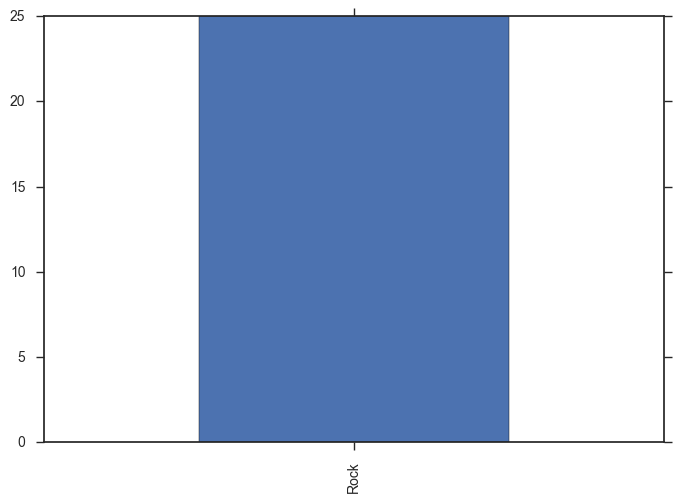

In [54]:
# Create a new dataframe with just the song ids
x_test_song_id_labels = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)][['song_id', 'artist', 'title', 'genre']].reset_index(drop = True)

# Append the predicted values to the song ids
x_test_song_id_labels['y_test_pred'] = pd.Series(lb.inverse_transform(y_test_pred))

# Group by and find the most commonly classified genre of each frame per song
song_classification = x_test_song_id_labels.groupby(['song_id'])['y_test_pred'].agg(lambda x: x.value_counts().idxmax()).reset_index()

# Plot histogram of predicted song genres
song_classification['y_test_pred'].value_counts().plot(kind = 'bar')

Well, that's annoying. Somehow, it's guessing all rock now. How do the distribution of the predicted frames look like?

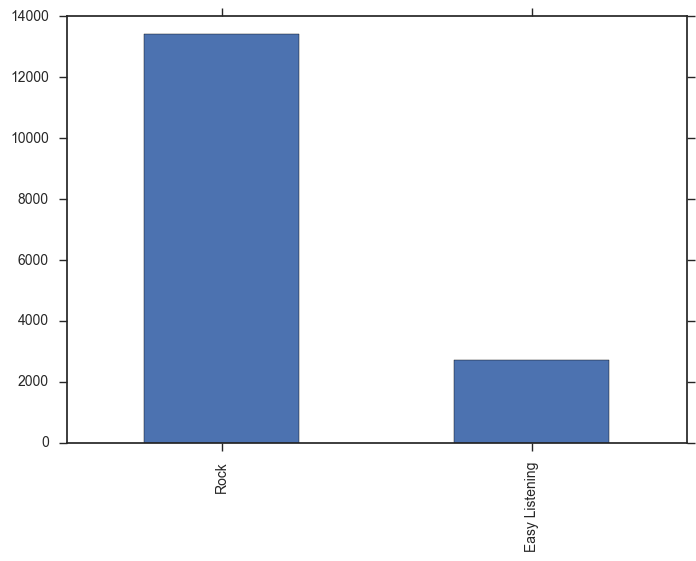

In [55]:
x_test_song_id_labels['y_test_pred'].value_counts().plot(kind = 'bar')

Let's take a look at the song themselves.

In [56]:
# Add counter for counting frames
x_test_song_id_labels['counter'] = 1

# Find the percentage of frames that were classified as Rock and Easy Listening in each song
y_pred_song_table = pd.pivot_table(x_test_song_id_labels, values = 'counter', index = ['song_id', 'artist', 'title', 'genre'], columns = ['y_test_pred'], aggfunc = np.sum).reset_index()

# Calculate percentages of frames
total_frames = 646
y_pred_song_table['Easy Listening %'] = y_pred_song_table['Easy Listening'] / 646
y_pred_song_table['Rock %'] = y_pred_song_table['Rock'] / 646

# Show table
y_pred_song_table

y_test_pred,song_id,artist,title,genre,Easy Listening,Rock,Easy Listening %,Rock %
0,1213,Fleetwood Mac,Dreams (Flight Facilities Remix),Rock,50,596,0.077399,0.922601
1,1379,Green Day,Wake Me Up When September Ends,Rock,52,594,0.080495,0.919505
2,1667,Jewel,Foolish Games,Easy Listening,173,473,0.267802,0.732198
3,1742,Julie London,Cry Me A River,Easy Listening,237,409,0.366873,0.633127
4,1745,Julie London,I'm Glad There Is You,Easy Listening,217,429,0.335913,0.664087
5,1749,Julie London,It Never Entered My Mind,Easy Listening,287,359,0.444272,0.555728
6,1759,Julie London,Spring Is Here,Easy Listening,273,373,0.422601,0.577399
7,2420,Norah Jones,Happy Pills,Rock,150,496,0.232198,0.767802
8,2422,Norman Greenbaum,Spirit In The Sky,Rock,65,581,0.100619,0.899381
9,2519,Pink Floyd,Speak To Me - Breathe,Rock,50,596,0.077399,0.922601


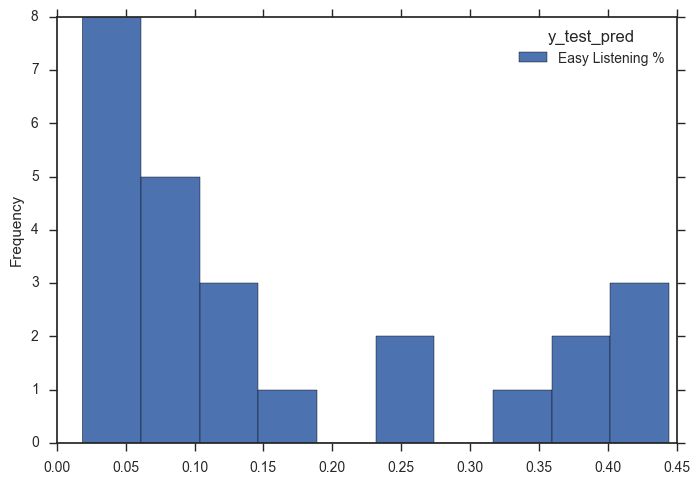

In [58]:
y_pred_song_table[['Easy Listening %']].plot.hist()

Here, we're looking at the distribution of songs that are classified as Easy Listening as a percentage. There is that gap right at 0.25 where we could probably make the split. Let's see what happens if we
- Classify anything _**greater than or equal to 25% Easy Listening %**_ as Easy Listening
- Classify anything _**less than 25% Easy Listening %**_ as Rock

In [59]:
# Perform manual classification
y_pred_song_table['y_test_pred_label'] = np.where(
    y_pred_song_table['Easy Listening %'] >= 0.25,
    'Easy Listening',
    'Rock'
)

In [64]:
# Print confusion matrix
confusion_matrix(y_pred_song_table['genre'], y_pred_song_table['y_test_pred_label'])

array([[ 7,  2],
       [ 0, 16]])

<span style="color:red; font-size: 3em;">**Holy cow, it got 23 / 25 songs!!!!!!!!!!!!!!!!!**</span>

![](https://i.giphy.com/media/xeXEpUVvAxCV2/giphy.webp)

Let's look at the songs it didn't get.

In [68]:
# Calculate whether or not the prediction was correct
y_pred_song_table['prediction_correct'] = np.where(
    y_pred_song_table['genre'] == y_pred_song_table['y_test_pred_label'],
    True,
    False
)

# Show songs incorrectly predicted
y_pred_song_table[y_pred_song_table['prediction_correct'] == False]

y_test_pred,song_id,artist,title,genre,Easy Listening,Rock,Easy Listening %,Rock %,y_test_pred_label,prediction_correct
13,2716,Robbie Williams & Nicole Kidman,Something Stupid,Easy Listening,84,562,0.130031,0.869969,Rock,False
14,2842,Sam Smith,Stay With Me,Easy Listening,100,546,0.154799,0.845201,Rock,False


Hmm, I'm not quite sure why "Something Stupid" was classified as Rock, but I can see how "Stay With Me" could be. It's got a heavier drums whereas some songs I classified as Easy Listening have no percussion whatsoever. This is a pretty good example of how my categorizations could've gone either way!

[![IMAGE ALT TEXT](http://img.youtube.com/vi/pB-5XG-DbAA/0.jpg)](http://www.youtube.com/watch?v=pB-5XG-DbAA "Video Title")

Looking back, I should have probably classified this as pop... but hey... I was literally trying to get through each song within 5 seconds so I'd have the rest of my life back to actually build the model.

Overall, I'm extremely happy with how this turned out. For what I wanted to get out of this project, this was awesome. I came in not even knowing how to think about a song, and now I've had _**some**_ moderate success even being able to classify songs with diverse genres. I'm not trying to build a startup or sell a product or anything, so I'm not looking for 100% accuracy. Just developing that train of thought and understanding how to break down this type of problem is what I'm interested in, and I think I've gotten 80% there. Of course, that last 20% is what will build the real product and what people go to school for. I'm just a lowly naive generalist who's just looking to scratch the surface for now.

I kind of also want to try a neural network out for fun. There's a ton of talk around [Tensorflow](https://www.tensorflow.org/) these days... Shall we?